## Abstract
In this post I will be looking into the concepts of overfitting, overparameterization, and double descent through some  linear regression experiments using random features. I began by implementing a custom linear model and optimizer that supports overparameterized settings using the Moore-Penrose pseudoinverse. I thentested the model on both synthetic nonlinear data and a real-world image corruption task. By changinge the number of random features, I was able to observe the double descent pattern in test error, showing how the model performance can improve even beyond the interpolation threshold.


### Part 0
In Equation 1, the equation $(X^T X)^{-1}$ requires for $X^T X$ to be invertible. And this can only happen when the number of data points $n$ is greater than or equal to the number of features $p$. So if we have $p > n$, then $X^T X$ becomes a singular matrix and it doesn’t have full rank( meaning it cant be inverted then)so our formula wont work.

### Part A
In my [LY.py](https://github.com/Pbabu-Github/csci-0451/blob/main/posts/Overfitting%2C%20Overparameterization%2C%20and%20Double%20Descent/LR.py) file I created a regression model called MyLinearRegression that predicts outputs and calculates the mean-squared error loss. I also implemented an optimizer OverParameterizedLinearRegressionOptimizer that fits the model using the pseudoinverse. This allows the model to work even in the overparameterized setting, when our traditional matrix inversion is not possible.



In [1]:
# Import our libraries
%load_ext autoreload
%autoreload 2
from LR import MyLinearRegression, OverParameterizedLinearRegressionOptimizer
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Part B
In the code below, I generated a 1D dataset. I also created a randmon features class to apply a random feature transformation to make the data linearly separable in the new feature space, and then I will fit my linear regression model to this transfomed data.

In [2]:

# creating 1d data
X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype=torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

#Define square activation
def square(x):
    return x**2

# Creating a RandomFeatures class to generate random features
class RandomFeatures:
    def __init__(self, n_features, activation=square):
        self.n_features = n_features
        self.activation = activation
        self.u = None
        self.b = None

    def fit(self, X):
        self.u = torch.randn((X.size(1), self.n_features), dtype=torch.float64)
        self.b = torch.rand((self.n_features), dtype=torch.float64)

    def transform(self, X):
        return self.activation(X @ self.u + self.b)


I will now transorm our features and fit our model based of teh model we created. I then did teh predictions and plotted a graph to view it.

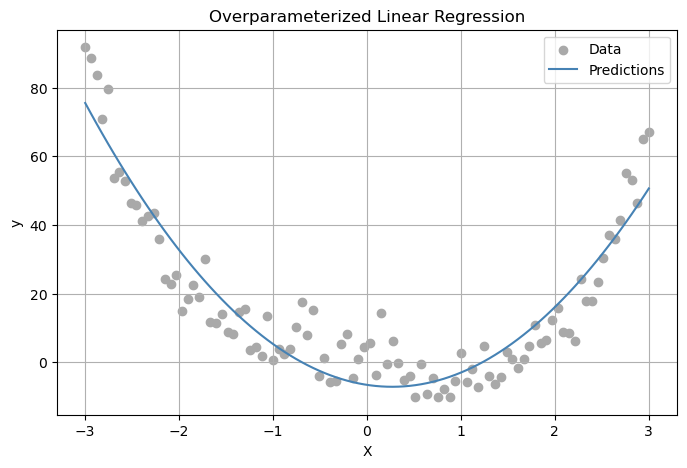

In [3]:

# trnasform our features and fit model
phi = RandomFeatures(n_features=300, activation=square)
phi.fit(X)

X_phi = phi.transform(X)

model = MyLinearRegression()
opt = OverParameterizedLinearRegressionOptimizer(model)
opt.fit(X_phi, y)

# making our prediction and plotting them
y_pred = model.predict(X_phi).detach()

plt.figure(figsize=(8, 5))
plt.scatter(X.numpy(), y.numpy(), color='darkgrey', label='Data')
plt.plot(X.numpy(), y_pred.numpy(), color='steelblue', label='Predictions')
plt.title("Overparameterized Linear Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In our graph about our plot shows that the model gets the general trend of the data very well. Despite the noise in the data, the predictions (which is the blue line) follow the overall U-shaped curve, which matches the true underlying function. This tell us that the random feature mapping allowed the linear model to learn a nonlinear relationship. This showse that our overparameterized linear regression setup is working well.

### Part C

So we are trying to predict how many corruptions there are in an image. I will do this by first loading our image, then corrupting it multiple times to create a dataset. We will the fit our model using RandomFeatures and the vary n_features to see the double descent in test and training error.

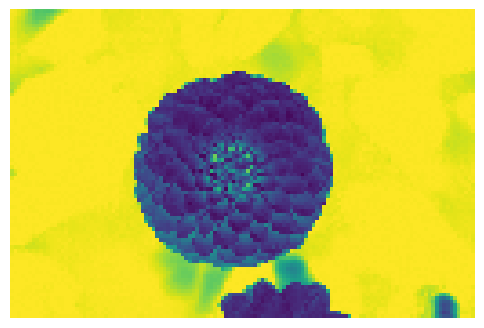

In [4]:
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom

dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X,.2) #decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(flower)
off = ax.axis("off")

Lets add our function that function that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍adds ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍random ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍number of randomly sized greay patches to the image and also returns teh number of patches added ‍‍‍‍‍‍‍‍‍‍‍‍‍. Lets then create a corrupted image using that function.

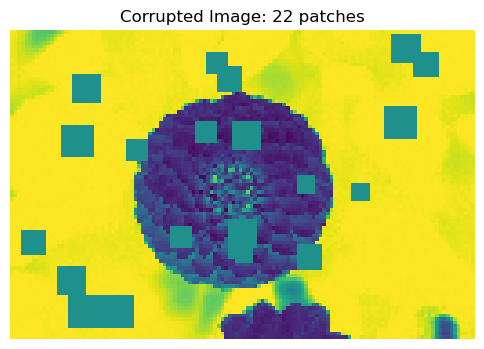

In [5]:
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

# Create a corrupted image

X, y = corrupted_image(flower, mean_patches = 50)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X.numpy(), vmin = 0, vmax = 1)
ax.set(title = f"Corrupted Image: {y} patches")
off = plt.gca().axis("off")

In our code below we create a dataset of corrupted imagesand also ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍reshape ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍image. ‍‍‍‍‍We then split ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍into ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍training ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍and ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍test ‍sets.

In [6]:
n_samples = 200
X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype=torch.float64)
y = torch.zeros(n_samples, dtype=torch.float64)

for i in range(n_samples):
    X[i], y[i] = corrupted_image(flower, mean_patches=100)

X = X.reshape(n_samples, -1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

### Asessing our model performance on this dataset
To see how changing the number of features affects the performance of my model, I used the same RandomFeatures transformation from before, but each time with a different number of features—from 10 to 200.

For each value of n_features:

* I Created random features for the training and test data,

* Trained my linear regression model using those features,

* Measured how well the model did on both the training and test data.

Then I stored the training and test errors so I can plot how they change as the model becomes more complex whic I will use later to see the double descent happening.



In [7]:
## we will use the same random features function as before

train_errors = []
test_errors = []
n_feature_list = list(range(10, 201))

for n_features in n_feature_list:
    phi = RandomFeatures(n_features=n_features, activation=square) # creating random features
    phi.fit(X_train) # fitting the random features
    X_train_phi = phi.transform(X_train) # transforming the training data
    X_test_phi = phi.transform(X_test) # transforming the test data

    model = MyLinearRegression()
    opt = OverParameterizedLinearRegressionOptimizer(model)
    opt.fit(X_train_phi, y_train)

    train_loss = model.loss(X_train_phi, y_train).item() # calculating the loss on our training data
    test_loss = model.loss(X_test_phi, y_test).item() # calculating the loss on our test data
    
    train_errors.append(train_loss)# adding the training loss to the list
    test_errors.append(test_loss) # adding the test loss to the list


Plotting our results

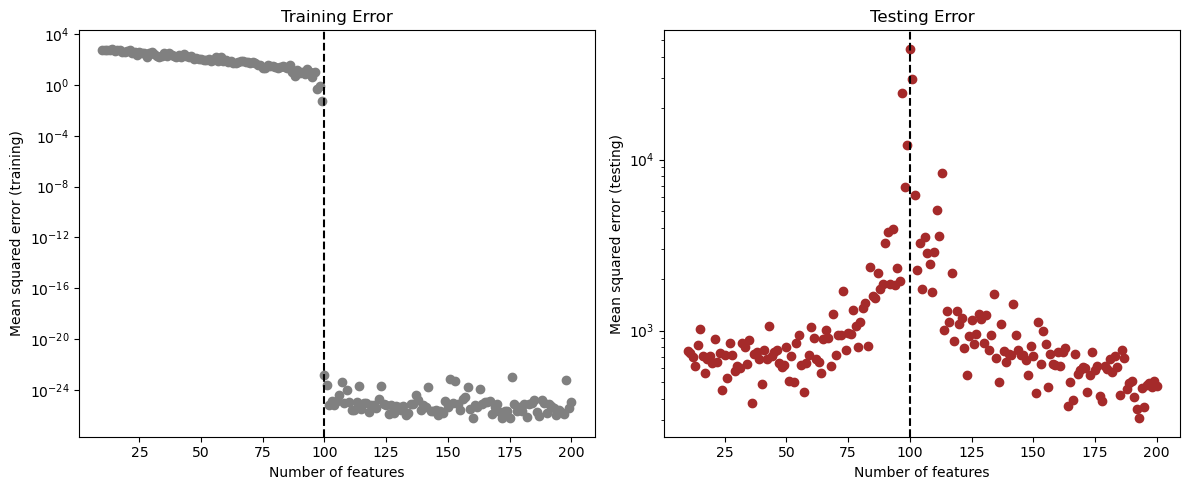

In [9]:
interp_threshold = X_train.shape[0]

plt.figure(figsize=(12, 5))

# Training Error
plt.subplot(1, 2, 1)
plt.plot(n_feature_list, train_errors, 'o', color='gray')
plt.axvline(interp_threshold, color='black', linestyle='--')
plt.yscale('log')
plt.xlabel("Number of features")
plt.ylabel("Mean squared error (training)")
plt.title("Training Error")

# Test Error
plt.subplot(1, 2, 2)
plt.plot(n_feature_list, test_errors, 'o', color='brown')
plt.axvline(interp_threshold, color='black', linestyle='--')
plt.yscale('log')
plt.xlabel("Number of features")
plt.ylabel("Mean squared error (testing)")
plt.title("Testing Error")

plt.tight_layout()
plt.show()


### Analyzing Double Descent Graph

From the plots, we can see the double descent happening. As we increase the number of random features:

* The training error decreases and becomes almost zero after the interpolation threshold (where the number of features equals the number of training samples).

* The test error first decreases and then it goes up a little near the threshold, and then decreases again as we go into the overparameterized area.

The best testing error occurred at around 180 features, which is above the interpolation threshold of 100. This supports the idea that interpolation is not always bad, and going beyond the threshold can still sometmies lead to a better generalization.

### Discussion
Through these experiments, I learned how increasing model complexity and overfitting does not always lead to worse generalization;even when a model can perfectly fit the training data. The double descent shows us that test error can decrease again after the interpolation threshold, contradicting the classical view of overfitting. This taught me that, with the right feature transformations, highly overparameterized models can still be effective. Completing this post helped me understand the trade-offs in model complexity and the behavior of test performance in modern machine learning which was really interesting to learn!

